
# Predictive Modeling of the Ames Housing Data

---

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

# import the saved data frame
openpath = '../pkl/house_df_pca.pkl'
if os.path.exists(openpath):
    house_df = pd.read_pickle(openpath)
else:
    print('File does not exist!')

### Train and Test Split
We need to split our data into training and testing dataset and seperate our target variable from our predicting features


In [2]:
from sklearn.model_selection import train_test_split
X = house_df.drop('SalePrice',axis=1)
y = house_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Model Selection
We are going to fit a number of models to see which one works best for predicting the houses' Sales Price. Once the model is selected, we will fine-tune the hyper-parameters to get the most performance.

In this example, we will explore the following models:

    1) Lasso
    2) ElasticNet
    3) Gradient Boost
    4) Random Forest

Finally, we use model-stacking to create a composite model consisting of the ones shown above

In [3]:
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# LassoCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LassoCV())
])

pipe.fit(X_train,y_train)
print('')
print('-------- LassoCV --------')
print('Train score: {}'.format(pipe.score(X_train,y_train)) )
print('Test score: {}'.format(pipe.score(X_test,y_test)) )

# ElasticNetCV
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNetCV())
])

pipe.fit(X_train,y_train)
print('')
print('-------- ElasticNetCV --------')
print('Train score: {}'.format(pipe.score(X_train,y_train)) )
print('Test score: {}'.format(pipe.score(X_test,y_test)) )

# RandomForestRegressor
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

pipe.fit(X_train,y_train)
print('')
print('-------- RandomForestRegressor --------')
print('Train score: {}'.format(pipe.score(X_train,y_train)) )
print('Test score: {}'.format(pipe.score(X_test,y_test)) )

# GradientBoostingRegressor
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

pipe.fit(X_train,y_train)
print('')
print('-------- GradientBoostingRegressor --------')
print('Train score: {}'.format(pipe.score(X_train,y_train)) )
print('Test score: {}'.format(pipe.score(X_test,y_test)) )


-------- LassoCV --------
Train score: 0.9329063305852998
Test score: 0.920601771594917

-------- ElasticNetCV --------
Train score: 0.9328871302225534
Test score: 0.9202507037795806

-------- RandomForestRegressor --------
Train score: 0.9751558560480239
Test score: 0.8648121157097036

-------- GradientBoostingRegressor --------
Train score: 0.9680511984032989
Test score: 0.8966194970622847


### Model Tuning
The Linear Regression model with Lasso regularization appears to be the best performing model, so we will select this going forward to optimize the model's hyper-parameters.

In [44]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LassoCV(alphas=np.logspace(-3,0,100),
                          random_state=42,
                          cv=ShuffleSplit(n_splits=5, random_state=42)))
])

_ = pipe.fit(X_train, y_train)

print('')
print('------- Model-Tuning Summary -------')
print('')
print("Optimal Alpha: {}".format(pipe.named_steps['regressor'].alpha_))
print("Final Test Score: {}%".format(pipe.score(X_test,y_test)*100))


------- Model-Tuning Summary -------

Optimal Alpha: 0.002848035868435802
Final Test Score: 92.11697570039415%


### Examine Lasso Results

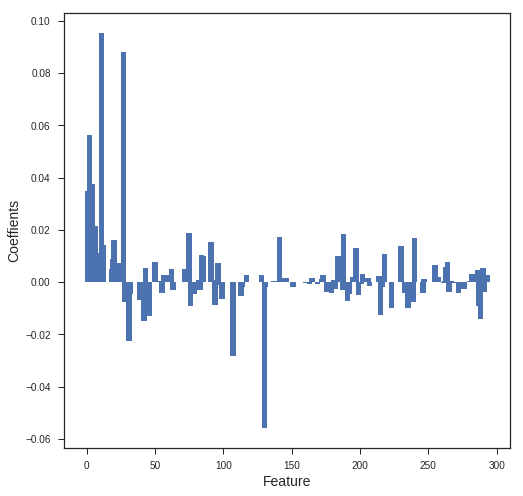

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

# Extract feature coefficients and names
coef = np.array(pipe.named_steps['regressor'].coef_)
names = X_train.columns

# Plot
_ = plt.figure(figsize=(8,8))
_ = plt.bar(left=np.arange(coef.shape[0]),
            height=coef, width=4)
_ = plt.xlabel('Feature',fontsize=14)
_ = plt.ylabel('Coeffients',fontsize=14)

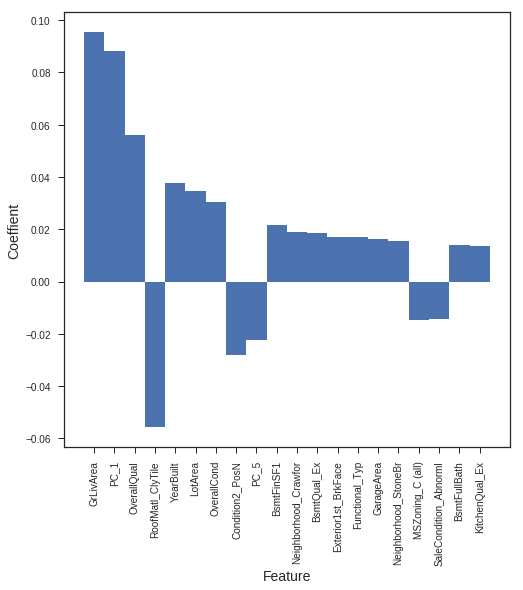

In [60]:
# zip the data together and create a list of tuples of non-zero coefficients
coef_list = [(i,val) for i,val in list(zip(names,coef)) if val!=0.0]

# sort the list by the absolute value of the coefficient
coef_list.sort(key=lambda x: abs(x[1]),reverse=True)

# create new figure
_ = plt.figure(figsize=(8,8))

# plot top 20 features
_ = plt.bar(left=np.arange(len(coef_list[0:20])),
            height=list(zip(*coef_list))[1][0:20], width=1)

# Set x-ticks to the feature names
_ = plt.xticks(np.arange(len(coef_list[0:20])), 
               list(zip(*coef_list))[0][0:20],
               rotation='vertical')
# Label axis
_ = plt.xlabel('Feature',fontsize=14)
_ = plt.ylabel('Coeffient',fontsize=14)

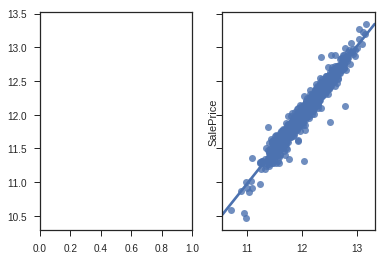

In [83]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.regplot(x=train_preds, y=y_train)



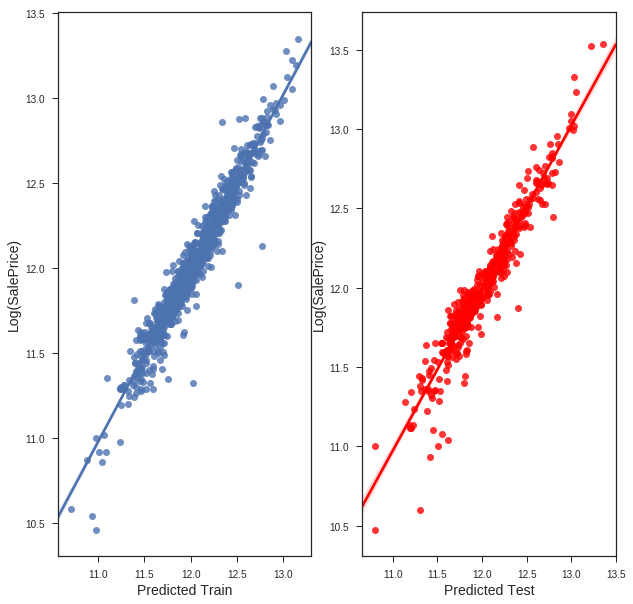

In [91]:
import seaborn as sns
# Calculate Training and Test Predicted SalePrice
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

# Plot Predicted vs. Actual SalePrice
_ = plt.figure(figsize=(10,10))
ax1 = plt.subplot(121)
_ = sns.regplot(x=train_preds, y=y_train)
_ = plt.xlabel('Predicted Train',fontsize=14)
_ = plt.ylabel('Log(SalePrice)',fontsize=14)
ax2 = plt.subplot(122)
_ = sns.regplot(x=test_preds, y=y_test,color='r')
# Label axis
_ = plt.xlabel('Predicted Test',fontsize=14)
_ = plt.ylabel('Log(SalePrice)',fontsize=14)